## Music Genre Classification using Genetic Algorithm and SVM

### Import required Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.ensemble as ske
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
seed = 12
np.random.seed(seed)
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('Data/features_3_sec.csv')

In [3]:
df.shape

(9990, 60)

In [4]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [5]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,jazz,1000
1,pop,1000
2,blues,1000
3,reggae,1000
4,metal,1000
5,disco,999
6,hiphop,998
7,rock,998
8,classical,998
9,country,997


In [6]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

In [7]:
# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
norm_data = min_max_scaler.fit_transform(X)
X = pd.DataFrame(norm_data, columns = cols)

### Null values

In [8]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [9]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [10]:
# update labels in df 
df.label = [label_index[l] for l in df.label]

In [11]:
# shuffle samples
shuffle_data = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [12]:
# remove irrelevant columns
shuffle_data.drop(['filename', 'length'], axis=1, inplace=True)
df_target = shuffle_data.pop('label')
df_X = shuffle_data

In [13]:
# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_target, train_size=0.7, random_state=seed, stratify=df_target)
X_val, X_test, y_val, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [14]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_target)} which is {round(X_train.shape[0]/len(df_target)*100)}%")
print(f"Dev set has {X_val.shape[0]} records out of {len(df_target)} which is {round(X_val.shape[0]/len(df_target)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_target)} which is {round(X_test.shape[0]/len(df_target)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [15]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#X_val = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [16]:
y_val

5991    7
5908    1
2673    0
9340    4
23      6
       ..
6862    7
3763    9
3049    1
8080    9
5437    7
Name: label, Length: 1978, dtype: int64

## Model Building for Classification 

### Feature Selection using Genetic Algorithm

#### steps for the genetic algorithm

In [17]:
def population(size,n_feat):
    pop = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        pop.append(chromosome)
    return pop

def fitness_score(pop):
    scores = []
    for chromosome in pop:
        svm_classifier.fit(X_train.iloc[:,chromosome],y_train)
        y_pred = svm_classifier.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,y_pred))
    scores, pop = np.array(scores), np.array(pop) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(pop[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    next_pop = []
    for i in range(n_parents):
        next_pop.append(pop_after_fit[i])
    return next_pop

def crossover(pop_after_sel):
    next_pop=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:40]=pop_after_sel[(i+1)%len(pop_after_sel)][3:40]
        next_pop.append(child)
    return next_pop

def mutation(pop_after_cross,mutation_rate):
    next_pop = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        next_pop.append(chromosome)
    return next_pop

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    next_pop=population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(next_pop)
        print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        next_pop = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

### Testing Genetic Algorithm

In [20]:
cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

In [21]:
svm_classifier = SVC(C=50, probability = True, class_weight=cl_weight,kernel='rbf')
svm_classifier.fit(X_train, y_train)

SVC(C=50,
    class_weight={0: 0.1001001001001001, 1: 0.0998998998998999,
                  2: 0.0997997997997998, 3: 0.1, 4: 0.0998998998998999,
                  5: 0.1001001001001001, 6: 0.1001001001001001,
                  7: 0.1001001001001001, 8: 0.1001001001001001,
                  9: 0.0998998998998999},
    probability=True)

In [23]:
a=population(3,57)

In [24]:
fitness_score(a)

([0.8910696761530913, 0.8714425907752699, 0.8626104023552502],
 [array([False,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True, False,  True, False, False, False,  True,  True,
         False,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True, False,  True, False, False,  True,
          True,  True,  True, False, False,  True,  True, False,  True,
         False,  True, False]),
  array([ True,  True,  True,  True, False, False,  True,  True, False,
          True, False,  True,  True,  True, False, False,  True,  True,
          True,  True, False, False, False,  True,  True,  True, False,
          True,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False, False,
          True,  True,  True,  True, False,  True,  True,  True, False,
         False, False,  True]),
  array([

In [28]:
scores = [0.8910696761530913, 0.8714425907752699, 0.8626104023552502]

In [29]:
b = selection(a,3)
b

[array([ True,  True,  True,  True,  True, False, False,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False, False,  True, False,  True,  True,  True,
        False, False,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False,  True,  True,  True, False,
        False, False,  True]),
 array([ True, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True, False, False, False,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, False,
        False,  True,  True]),
 array([False,  True,  True,  True,  True, False, False,  True, False,
         True, 

In [30]:
c = [];
for i in range(len(b)):
        child=b[i]
        child[3:40]=b[(i+1)%len(b)][3:40]
        c.append(child)

In [31]:
b[1][3:40]

array([ True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True])

In [32]:
chromo,score=generations(size=10,n_feat=57,n_parents=10,mutation_rate=0.10,
                     n_gen=10,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)


[0.8822374877330716, 0.8822374877330716]
[0.8861629048086359, 0.8861629048086359]
[0.8832188420019627, 0.8832188420019627]
[0.8842001962708538, 0.8842001962708538]
[0.8900883218842002, 0.8900883218842002]


## Apply selected features from GA to ML Model for classification

### ML Model - SVM

In [33]:
svm_classifier.fit(X_train.iloc[:,chromo[-1]],y_train)

SVC(C=50,
    class_weight={0: 0.1001001001001001, 1: 0.0998998998998999,
                  2: 0.0997997997997998, 3: 0.1, 4: 0.0998998998998999,
                  5: 0.1001001001001001, 6: 0.1001001001001001,
                  7: 0.1001001001001001, 8: 0.1001001001001001,
                  9: 0.0998998998998999},
    probability=True)

In [34]:
y_pred = svm_classifier.predict(X_test.iloc[:,chromo[-1]])
print("Accuracy score after genetic algorithm is= "+str(accuracy_score(y_test,y_pred)))

Accuracy score after genetic algorithm is= 0.8694798822374877


In [35]:
print(skm.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.892     0.854       102
           1      0.925     0.980     0.952       101
           2      0.736     0.765     0.750       102
           3      0.804     0.843     0.823       102
           4      0.917     0.863     0.889       102
           5      0.902     0.902     0.902       102
           6      0.914     0.941     0.928       102
           7      0.948     0.892     0.919       102
           8      0.920     0.902     0.911       102
           9      0.820     0.716     0.764       102

    accuracy                          0.869      1019
   macro avg      0.871     0.870     0.869      1019
weighted avg      0.871     0.869     0.869      1019



In [36]:
#y_pred_proba_X = svm_classifier.predict_proba(X_test.iloc[:,chromo[0]])

In [37]:
y_pred_X = svm_classifier.predict(X_test.iloc[:,chromo[-1]])

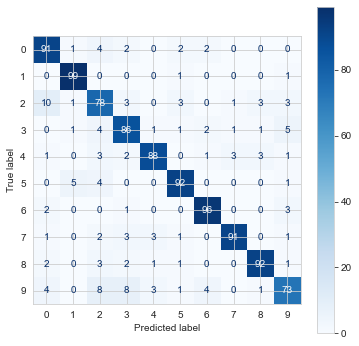

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
skm.plot_confusion_matrix(svm_classifier, X_test.iloc[:,chromo[-1]], y_test,cmap=plt.cm.Blues, ax=ax)
plt.show()

In [39]:
print(skm.classification_report(y_test, y_pred_X, digits=3))

              precision    recall  f1-score   support

           0      0.820     0.892     0.854       102
           1      0.925     0.980     0.952       101
           2      0.736     0.765     0.750       102
           3      0.804     0.843     0.823       102
           4      0.917     0.863     0.889       102
           5      0.902     0.902     0.902       102
           6      0.914     0.941     0.928       102
           7      0.948     0.892     0.919       102
           8      0.920     0.902     0.911       102
           9      0.820     0.716     0.764       102

    accuracy                          0.869      1019
   macro avg      0.871     0.870     0.869      1019
weighted avg      0.871     0.869     0.869      1019



In [40]:
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(y_pred_X), len(label_index))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, y_pred_X)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, y_pred_X, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

In [41]:
# Predict
pred_probs = svm_classifier.predict_proba(X_test.iloc[:,chromo[-1]])

In [42]:
print(f1_score(y_test, y_pred_X , average='macro'))

0.8692216497143488


In [43]:
# Results
display_results(y_test, pred_probs)



Test Set Accuracy =  0.87
Test Set F-score =  0.87
ROC AUC = 0.989
